In [1]:
import pandas as pd

In [2]:
from datetime import datetime

def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

def parse_time(x):
  dt = datetime.fromtimestamp(x['TIMESTAMP'])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.timetuple().tm_yday
#   return dt.year, dt.month, dt.day, dt.hour, dt.timetuple().tm_yday

import math 
from datetime import datetime
    
def parse_midnight_minutes(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    sinn = (math.sin(2 * ((dt.hour * 60 + dt.minute) / 1440) * math.pi) + 1) / 2
    return sinn

In [3]:
train_df = pd.read_csv('archive/train.csv')

In [4]:
train_df.shape

(1710670, 9)

In [5]:
train_df_added_len =  train_df
train_df_added_len["LEN"] = train_df_added_len["POLYLINE"].apply(polyline_to_trip_duration)

In [6]:
train_df_added_time = train_df_added_len
train_df_added_time[["YR", "MON", "DAY", "HR", 'WK', "DAYOFYEAR"]] = train_df_added_time[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [7]:
import numpy as np
import pandas as pd

test_df = pd.read_csv('archive/test_public.csv')
test_df[["YR", "MON", "DAY", "HR", 'WK', "DAYOFYEAR"]] = test_df[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

unique_test_day_of_year = np.array(test_df['DAYOFYEAR'].value_counts().keys()) 
#datahub time zone produces 5 instead of 6 unique test days of years
# unique_test_day_of_year = [[273, 279, 226, 305, 355]]
#this produces 6
train_df_filtered_DOY = train_df_added_time[train_df_added_time['DAYOFYEAR'].isin(unique_test_day_of_year)]


In [8]:
# train_df_added_time['DAYOFYEAR'].value_counts()
train_df_filtered_DOY.shape

(28467, 16)

In [9]:
train_df_filtered_outliers_removed = train_df_filtered_DOY

In [10]:
import numpy as np

q1,median,q3 = np.percentile(train_df_filtered_outliers_removed["LEN"],q=[25,50,75])
IQR = q3 - q1
lowerBound = q1 - 1.25 * IQR
upperBound = q3 + 1.25 * IQR

print('lowerBound: ', lowerBound)
print('upperBound: ', upperBound)
df_trimmed = train_df_filtered_outliers_removed[train_df_filtered_outliers_removed["LEN"] > lowerBound]
df_trimmed = df_trimmed[df_trimmed["LEN"] < upperBound]
print("Before Trimming: " + str(len(train_df_filtered_outliers_removed)))
print("After Trimming: " + str(len(df_trimmed)))
mean, std, min, max = df_trimmed["LEN"].mean(), df_trimmed["LEN"].std(), df_trimmed["LEN"].min(), df_trimmed["LEN"].max()
median = df_trimmed["LEN"].median()
print(mean, median, std, min, max)

lowerBound:  -176.25
upperBound:  1451.25
Before Trimming: 28467
After Trimming: 26781
611.7503080542175 570.0 307.1476608416404 0 1440


In [11]:
unique_trip_times = np.array(df_trimmed['LEN'].value_counts().keys())

len_to_index_dict = {}
index_to_len_dict = {}

unique_trip_times.sort()

count = 0
for trip_time in unique_trip_times:
    len_to_index_dict[trip_time] = count
    index_to_len_dict[count] = trip_time
    count += 1

def LEN_to_index(x):
    return int(len_to_index_dict[x['LEN']])

df_indexed = df_trimmed
df_indexed['LEN_INDEX'] = df_indexed[["LEN"]].apply(LEN_to_index, axis=1, result_type="expand")



In [12]:
df_indexed

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,DAYOFYEAR,LEN_INDEX
200799,1376464254620000618,B,NaN,9.0,20000618,1376464254,A,False,"[[-8.606655,41.144688]]",0,2013,8,14,0,2,226,0
200816,1376463844620000281,A,23692.0,NaN,20000281,1376463844,A,False,"[[-8.564472,41.151609],[-8.564049,41.15187],[-...",405,2013,8,14,0,2,226,27
200824,1376463841620000271,B,NaN,21.0,20000271,1376463841,A,False,"[[-8.62875,41.160987],[-8.628768,41.160933],[-...",405,2013,8,14,0,2,226,27
200828,1376464905620000085,A,34648.0,NaN,20000085,1376464905,A,False,"[[-8.568342,41.151645]]",0,2013,8,14,0,2,226,0
200854,1376464260620000312,C,NaN,NaN,20000312,1376464260,A,False,"[[-8.613711,41.141187],[-8.613369,41.140773],[...",1140,2013,8,14,0,2,226,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823737,1387659576620000013,A,52728.0,NaN,20000013,1387659576,A,False,"[[-8.665632,41.170689],[-8.665605,41.170707],[...",1155,2013,12,21,12,5,355,77
823773,1387669140620000626,A,38431.0,NaN,20000626,1387669140,A,False,"[[-8.644428,41.176593],[-8.644257,41.176701],[...",990,2013,12,21,15,5,355,66
825392,1387628374620000065,A,48563.0,NaN,20000065,1387628374,A,False,"[[-8.643465,41.162625],[-8.643456,41.162724],[...",435,2013,12,21,4,5,355,29
860307,1387630074620000334,B,NaN,15.0,20000334,1387630074,A,False,"[[-8.585658,41.14854],[-8.585721,41.148693],[-...",690,2013,12,21,4,5,355,46


In [72]:
df_sorted = df_indexed.sort_values(by=['TIMESTAMP'])
df_sorted

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,DAYOFYEAR,LEN_INDEX
201177,1376463600620000342,A,18412.0,NaN,20000342,1376463600,A,False,"[[-8.623179,41.165055],[-8.62317,41.165064],[-...",630,2013,8,14,0,2,226,42
201101,1376463613620000529,B,NaN,36.0,20000529,1376463613,A,False,"[[-8.64945,41.154309],[-8.650152,41.154111],[-...",465,2013,8,14,0,2,226,31
201265,1376463705620000570,C,NaN,NaN,20000570,1376463705,A,False,"[[-8.60724,41.149359],[-8.607195,41.149692],[-...",435,2013,8,14,0,2,226,29
200959,1376463768620000163,C,NaN,NaN,20000163,1376463768,A,False,"[[-8.555724,41.204637],[-8.555805,41.206041],[...",1200,2013,8,14,0,2,226,80
200962,1376463831620000152,A,10521.0,NaN,20000152,1376463831,A,False,"[[-8.596899,41.15835],[-8.596935,41.15835],[-8...",525,2013,8,14,0,2,226,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817402,1387699091620000588,C,NaN,NaN,20000588,1387699091,A,False,"[[-8.683434,41.159061],[-8.683767,41.159475],[...",180,2013,12,21,23,5,355,12
820236,1387699105620000361,B,NaN,23.0,20000361,1387699105,A,False,"[[-8.612577,41.145903],[-8.61264,41.145921],[-...",870,2013,12,21,23,5,355,58
817558,1387699141620000104,C,NaN,NaN,20000104,1387699141,A,False,"[[-8.613297,41.166918],[-8.614152,41.166945],[...",285,2013,12,21,23,5,355,19
817714,1387699178620000247,C,NaN,NaN,20000247,1387699178,A,False,"[[-8.610831,41.161626],[-8.609949,41.161509],[...",510,2013,12,21,23,5,355,34


In [73]:
df_prepped = df_sorted.drop(columns=['TRIP_ID', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE'])


In [74]:
df_prepped

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK,DAYOFYEAR,LEN_INDEX
201177,A,18412.0,NaN,20000342,1376463600,630,2013,8,14,0,2,226,42
201101,B,NaN,36.0,20000529,1376463613,465,2013,8,14,0,2,226,31
201265,C,NaN,NaN,20000570,1376463705,435,2013,8,14,0,2,226,29
200959,C,NaN,NaN,20000163,1376463768,1200,2013,8,14,0,2,226,80
200962,A,10521.0,NaN,20000152,1376463831,525,2013,8,14,0,2,226,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817402,C,NaN,NaN,20000588,1387699091,180,2013,12,21,23,5,355,12
820236,B,NaN,23.0,20000361,1387699105,870,2013,12,21,23,5,355,58
817558,C,NaN,NaN,20000104,1387699141,285,2013,12,21,23,5,355,19
817714,C,NaN,NaN,20000247,1387699178,510,2013,12,21,23,5,355,34


In [75]:
# new_airline = pd.read_csv('airline.csv')

# new_airline['new_col'] = new_airline['Passengers'] - 5
# new_airline['zero'] = 0

# new_airline.to_csv('airlineaugment.csv', index=None)

In [76]:
LetterToIndex = {'A': 0, 'B': 1, 'C': 2}
df_prepped["CALL_TYPE"] = df_prepped["CALL_TYPE"].map(LetterToIndex)
df_prepped

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK,DAYOFYEAR,LEN_INDEX
201177,0,18412.0,NaN,20000342,1376463600,630,2013,8,14,0,2,226,42
201101,1,NaN,36.0,20000529,1376463613,465,2013,8,14,0,2,226,31
201265,2,NaN,NaN,20000570,1376463705,435,2013,8,14,0,2,226,29
200959,2,NaN,NaN,20000163,1376463768,1200,2013,8,14,0,2,226,80
200962,0,10521.0,NaN,20000152,1376463831,525,2013,8,14,0,2,226,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817402,2,NaN,NaN,20000588,1387699091,180,2013,12,21,23,5,355,12
820236,1,NaN,23.0,20000361,1387699105,870,2013,12,21,23,5,355,58
817558,2,NaN,NaN,20000104,1387699141,285,2013,12,21,23,5,355,19
817714,2,NaN,NaN,20000247,1387699178,510,2013,12,21,23,5,355,34


In [77]:
import numpy as np
def normalize(df_tr, features):
    for feature in features:
        print (feature)
        maxVal = np.max(df_tr[feature])
        minVal = np.min(df_tr[feature])
        if (maxVal == minVal):
            df_tr[feature] = 1.0
        else:
            df_tr[feature] = (df_tr[feature] - minVal) / (maxVal - minVal)

df_prepped["MIDNIGHTMIN"] = df_prepped[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
# df_prepped[df_prepped['HR'] == 3]



In [19]:
# featuresToNormalize = ["TAXI_ID", 'DAYOFYEAR', 'HR', 'WK', 'MON', 'CALL_TYPE']
# normalize(df_prepped, featuresToNormalize)


TAXI_ID
DAYOFYEAR
HR
WK
MON
CALL_TYPE


In [78]:
# df_prepped["MIDNIGHTMIN"] = df_prepped[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
# df_prepped[df_prepped['HR'] > .6]
# df_prepped['YR'].value_counts()
# df_prepped

print(df_prepped.shape)
acceptable_taxi_ids = np.array(pd.read_csv('archive/test_public.csv')['TAXI_ID'].value_counts().keys())
print(acceptable_taxi_ids.shape)
# print(np.array(df_prepped['TAXI_ID'].value_counts().keys()).shape)
df_prepped_dropped_ids = df_prepped[df_prepped['TAXI_ID'].isin(acceptable_taxi_ids)]
print(df_prepped_dropped_ids.shape)


(26781, 14)
(244,)
(15830, 14)


In [86]:
featuresToNormalize = ["TAXI_ID", 'DAYOFYEAR', 'HR', 'WK', 'MON', 'CALL_TYPE', 'DAY']
normalize(df_prepped_dropped_ids, featuresToNormalize)

TAXI_ID
DAYOFYEAR
HR
WK
MON
CALL_TYPE
DAY


C:\Users\kempe\AppData\Local\Temp\ipykernel_11732\2470827181.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr[feature] = (df_tr[feature] - minVal) / (maxVal - minVal)


In [87]:
df_prepped_dropped_ids

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK,DAYOFYEAR,LEN_INDEX,MIDNIGHTMIN
201177,0.0,18412.0,NaN,0.375556,1376463600,630,2013,0.0,0.32,0.0,0.333333,0.0,42,0.500000
201101,0.5,NaN,36.0,0.583333,1376463613,465,2013,0.0,0.32,0.0,0.333333,0.0,31,0.500000
200959,1.0,NaN,NaN,0.176667,1376463768,1200,2013,0.0,0.32,0.0,0.333333,0.0,80,0.504363
201029,0.5,NaN,36.0,0.650000,1376463836,405,2013,0.0,0.32,0.0,0.333333,0.0,27,0.506545
200816,0.0,23692.0,NaN,0.307778,1376463844,405,2013,0.0,0.32,0.0,0.333333,0.0,27,0.508726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817562,0.5,NaN,23.0,0.736667,1387699086,1245,2013,1.0,0.60,1.0,0.833333,1.0,83,0.495637
817357,0.5,NaN,27.0,0.570000,1387699088,300,2013,1.0,0.60,1.0,0.833333,1.0,20,0.495637
820236,0.5,NaN,23.0,0.396667,1387699105,870,2013,1.0,0.60,1.0,0.833333,1.0,58,0.495637
817714,1.0,NaN,NaN,0.270000,1387699178,510,2013,1.0,0.60,1.0,0.833333,1.0,34,0.497818


In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# df = pd.read_csv('airlineaugment.csv')
# df = df_prepped
# timeseries = df[["LEN_index", "new_col"]].values.astype('float32')
df_shaved = df_prepped_dropped_ids[-1000:]

important_features = ["LEN", "TAXI_ID", 'DAYOFYEAR', 'CALL_TYPE', 'WK', 'HR', "DAY"]
timeseries = df_shaved[important_features].values.astype('float32')


# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = 1
train, test = timeseries[:train_size], timeseries[train_size:]

# print(train)

# print(test.shape)

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback, 1:]
        target = dataset[i+1:i+lookback+1, 0:1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

Epoch 0: train RMSE 607.8053, test RMSE 649.4200
Epoch 100: train RMSE 474.8440, test RMSE 509.3694
Epoch 200: train RMSE 384.4455, test RMSE 408.9483
Epoch 300: train RMSE 327.9449, test RMSE 338.8372
Epoch 400: train RMSE 303.6208, test RMSE 300.5001
Epoch 500: train RMSE 298.6182, test RMSE 286.7819
Epoch 600: train RMSE 298.3691, test RMSE 284.2693
Epoch 700: train RMSE 298.3636, test RMSE 284.1216
Epoch 800: train RMSE 294.8636, test RMSE 282.2512
Epoch 900: train RMSE 293.5354, test RMSE 278.4103
Epoch 1000: train RMSE 293.2947, test RMSE 277.7149
Epoch 1100: train RMSE 293.2131, test RMSE 277.4548
Epoch 1200: train RMSE 293.1655, test RMSE 277.4764
Epoch 1300: train RMSE 293.0728, test RMSE 277.2224
Epoch 1400: train RMSE 287.5077, test RMSE 283.6484
Epoch 1500: train RMSE 279.6769, test RMSE 286.2527
Epoch 1600: train RMSE 271.2347, test RMSE 295.4103
Epoch 1700: train RMSE 264.9690, test RMSE 293.6583
Epoch 1800: train RMSE 255.7552, test RMSE 313.2759
Epoch 1900: train RMSE 2

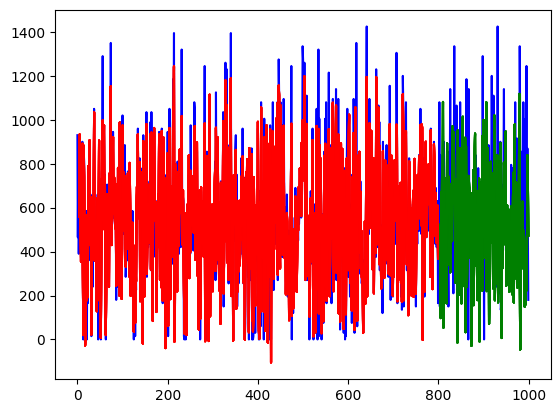

array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [839.1855 , 839.1855 , 839.1855 , ..., 839.1855 , 839.1855 ,
        839.1855 ],
       [749.1584 , 749.1584 , 749.1584 , ..., 749.1584 , 749.1584 ,
        749.1584 ],
       [472.64352, 472.64352, 472.64352, ..., 472.64352, 472.64352,
        472.64352]], dtype=float32)

In [94]:
# lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size=128
        self.lstm = nn.LSTM(input_size=len(important_features)-1, hidden_size=layer_size, num_layers=2, batch_first=True)
#         self.lstm2 = nn.LSTM(input_size=128, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(layer_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
#         x, _ = self.lstm2(x)
        x = self.linear(x)
        return x

model = LSTMModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64)

training_losses = []
validation_losses = []
n_epochs = 2500
divide = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         # Validation
    if epoch % divide != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        training_losses.append(train_rmse)
        validation_losses.append(test_rmse)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries[:, 0], c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

test_plot

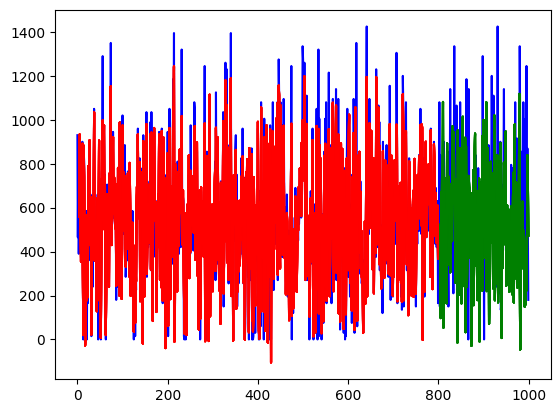

array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [839.1855 , 839.1855 , 839.1855 , ..., 839.1855 , 839.1855 ,
        839.1855 ],
       [749.1584 , 749.1584 , 749.1584 , ..., 749.1584 , 749.1584 ,
        749.1584 ],
       [472.64352, 472.64352, 472.64352, ..., 472.64352, 472.64352,
        472.64352]], dtype=float32)

In [95]:
model.eval()
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_preda = model(X_train)
    y_pred = y_preda[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    results = model(X_test)
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = results[:, -1, :]
# plot
plt.plot(timeseries[:, 0], c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()
test_plot

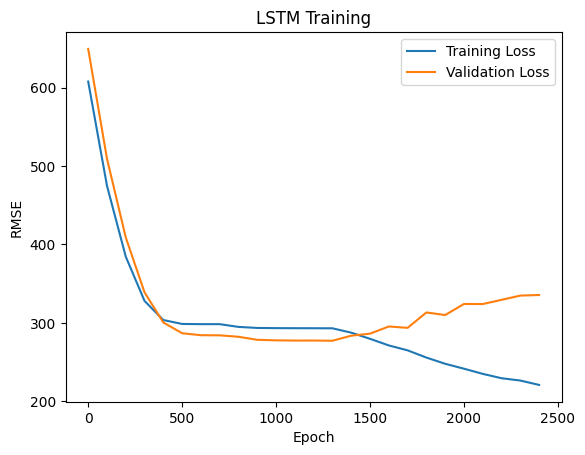

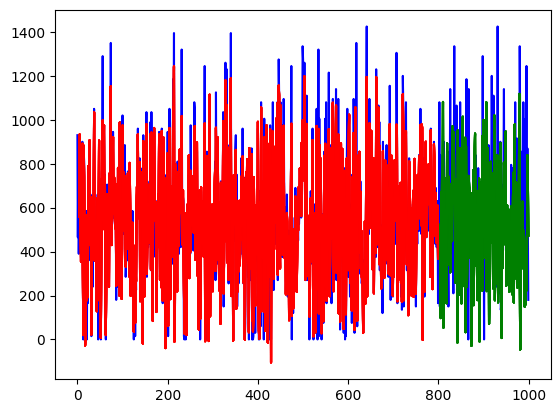

In [96]:
plt.title("LSTM Training")
plt.plot(range(0, len(training_losses) * divide, divide), training_losses, label = "Training Loss")
plt.plot(range(0, len(training_losses) * divide, divide), validation_losses, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.legend()
plt.show()

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    results = model(X_test)
    test_plot[train_size+lookback:len(timeseries)] = results[:, -1, :]
    
plt.plot(timeseries[:, 0], c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()
    


In [58]:
results.shape
# import pandas as pd
# np.array(results.flatten())
# pd.DataFrame(results.flatten()).value_counts()

# results[0]
# len(df_prepped) * .2
# pd.DataFrame(results[:, -1, :]).value_counts()

torch.Size([196, 4, 1])

In [97]:
# ["LEN", "TAXI_ID", 'DAYOFYEAR', 'HR', 'DAY']
import pandas as pd
from datetime import datetime
test_set = pd.read_csv('archive/test_public.csv')
test_set_added = test_set
test_set_added[["YR", "MON", "DAY", "HR", 'WK', "DAYOFYEAR"]] = test_set_added[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
test_set_added['LEN'] = 0

LetterToIndex = {'A': 0, 'B': 1, 'C': 2}
test_set_added["CALL_TYPE"] = test_set_added["CALL_TYPE"].map(LetterToIndex)
test_set_added["MIDNIGHTMIN"] = test_set_added[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")

normalize(test_set_added, featuresToNormalize)

TAXI_ID
DAYOFYEAR
HR
WK
MON
CALL_TYPE
DAY


In [98]:
test_set_added

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,DAYOFYEAR,LEN,MIDNIGHTMIN
0,T1,0.5,NaN,15.0,0.597778,1408039037,A,False,2014,0.0,0.32,0.434783,0.5,0.0,0,0.635720
1,T2,0.5,NaN,57.0,0.115556,1408038611,A,False,2014,0.0,0.32,0.434783,0.5,0.0,0,0.650353
2,T3,0.5,NaN,15.0,0.406667,1408038568,A,False,2014,0.0,0.32,0.434783,0.5,0.0,0,0.652432
3,T4,0.5,NaN,53.0,0.542222,1408039090,A,False,2014,0.0,0.32,0.434783,0.5,0.0,0,0.633619
4,T5,0.5,NaN,18.0,0.685556,1408039177,A,False,2014,0.0,0.32,0.434783,0.5,0.0,0,0.631516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,0.0,70885.0,NaN,0.473333,1419171485,A,False,2014,1.0,0.60,0.260870,1.0,1.0,0,0.998459
316,T324,0.5,NaN,53.0,0.017778,1419170802,A,False,2014,1.0,0.60,0.260870,1.0,1.0,0,0.999829
317,T325,1.0,NaN,NaN,0.225556,1419172121,A,False,2014,1.0,0.60,0.260870,1.0,1.0,0,0.996273
318,T326,0.0,76232.0,NaN,0.736667,1419171980,A,False,2014,1.0,0.60,0.260870,1.0,1.0,0,0.996786


In [99]:
import ast

In [1]:
# import datetime
import ast

# "LEN", "TAXI_ID", 'DAYOFYEAR', 'HR', 'WK', 'CALL_TYPE'

# Normalize the new feature values using the same normalization technique applied during training
# Apply the necessary normalization steps to 'new_feature1' and 'new_feature2'

window_size = lookback

# Create the input tensor for the LSTM model

# print(test_set_added['TRIP_ID'])
ids = np.array(test_set_added["TRIP_ID"])

trip_to_id = {}

incr = 0
for id in ids:
    trip_to_id[id] = incr
    incr += 1

print(trip_to_id)

# print(ids)
test_sorted = test_set_added.sort_values(by=['TIMESTAMP'])
test_sorted = test_sorted.reset_index(drop=True)
test_sorted

preds = list(np.zeros([320, ]))
print(preds)
for start in range(1, 800, 5):
    for ind in range(320):
        row = test_sorted[ind:ind+1]
        trip_id_t = row['TRIP_ID'].values[0]
        # print(trip_id_t)
        a = timeseries[start:start + window_size]
        # print(a)
        # print('row----')
        # print(np.array(row[important_features]))
        # print('row----')
        # print(row)
        # print(a)
        # a[-1] = np.array(row[important_features])
        # a.pop()
        a = a[1:]
        a = np.concatenate((a, np.array(row[important_features])))
        # a = np.append(a, np.array(row[important_features])) c
        # a = np.insert(a, window_size-1, np.array(row[important_features]))
        # print(a)
        # print(a)
        # print(a[:, 1:])  
        prediction_input = torch.tensor(a[:, 1:]).float()
        # print(prediction_input)
        # Set the model to evaluation mode
        model.eval()

    # Disable gradient calculation during inference
        with torch.no_grad():
            # Pass the input tensor through the model's forward() method to obtain the prediction
            prediction = model(prediction_input)

        # Post-process the prediction if necessary (e.g., reverse normalization)
        # preds.append(prediction[-1].item())
        # print(ast.literal_eval(trip_id_t[1:]) - 1)
        preds[trip_to_id[trip_id_t]] = prediction[-1].item()
        # print(row.TRIP_ID.values[0], prediction[-1].item())

    d = {"TRIP_ID" : ids, "TRAVEL_TIME" : preds}
    newdf = pd.DataFrame(d)

    newname = '486_2_lstm.csv'
    newdf.to_csv(newname, index=None)
    labels = pd.read_csv(newname)['TRAVEL_TIME']
    if (np.mean(labels) > 500 and np.mean(labels) < 650):
        print('mean', np.mean(labels))
        print('std', np.std(labels))
        print('median', np.median(labels))
        print('min', np.min(labels))
        print('max', np.max(labels))
        print('start: ', start)
        plt.title(start)
        plt.hist(labels, edgecolor='black')
        plt.show()

NameError: name 'lookback' is not defined

mean 588.0830424308776
std 58.69237471465404
median 598.5754089355469
min 441.39892578125
max 714.2048950195312


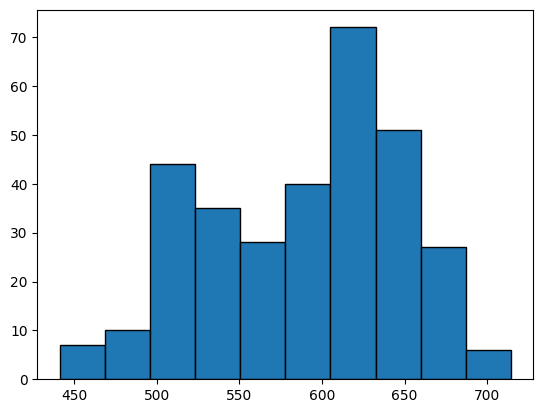

In [118]:
labels = pd.read_csv(newname)['TRAVEL_TIME']
print('mean', np.mean(labels))
print('std', np.std(labels))
print('median', np.median(labels))
print('min', np.min(labels))
print('max', np.max(labels))
plt.hist(labels, edgecolor='black')
plt.show()